In [1]:
import jax
import jax.numpy as jnp
from chewc.popgen import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import combine_populations, Population, subset_population # Add subset_population


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chewc.popgen import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross

# ==================================================
# ---  simulation_parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 20,
    "h2" : jnp.array([.3]),
    "key": jax.random.PRNGKey(42)
}
simulation_parameters['max_pop_size'] = int(simulation_parameters['population_size'] * simulation_parameters['n_generations'] * 1.5)
# ====

# --- Setup Founder Population and Traits using Parameters ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
    max_pop_size=simulation_parameters['max_pop_size']
)

# Create SimParam objects for sp1 (Normal) and sp2 (Gamma)
sp = SimParam.from_founder_pop(founder_pop, genetic_map)
sp = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
    gamma=False
)



genetic_means = []
genetic_variances = []
current_pop = founder_pop
next_id_start = current_pop.nInd
n_generations = simulation_parameters["n_generations"]
population_size = simulation_parameters["population_size"]
n_select = simulation_parameters["n_select"]
pheno_key, select_key, mate_key = jax.random.split(key, 3)

for gen in range(n_generations + 1):
    #set up JAX keys
    p_subkey, pheno_key = jax.random.split(pheno_key)
    s_subkey, select_key = jax.random.split(select_key)
    m_subkey1, m_subkey2, mate_key = jax.random.split(mate_key, 3)
    #calculate true breeding values
    current_pop = set_bv(current_pop, sp.traits, sp.ploidy)
    genetic_means.append(jnp.mean(current_pop.bv))
    genetic_variances.append(jnp.var(current_pop.bv))
    #measure phenotypes (with noise based on h2)
    current_pop = set_pheno(
        key=p_subkey, pop=current_pop, traits=sp.traits,
        ploidy=sp.ploidy, h2=jnp.array([simulation_parameters['h2'][0]])
    )
    #naive selection based on phenotype values (find top individuals)
    selected_indices = jnp.argsort(current_pop.pheno[:, 0])[-n_select:]
    mothers = jax.random.choice(m_subkey1, selected_indices, shape=(population_size,))
    fathers = jax.random.choice(m_subkey2, selected_indices, shape=(population_size,))
    #make pairs from these top individuals
    cross_plan = jnp.stack([mothers, fathers], axis=1)
    #create new population object with the offspring
    current_pop = make_cross(
        key=s_subkey, pop=current_pop, cross_plan=cross_plan,
        sp=sp, next_id_start=next_id_start
    )
    next_id_start += population_size
    

In [5]:
import jax
import jax.numpy as jnp
from jax import lax
import matplotlib.pyplot as plt
from functools import partial

# Assuming your chewc library functions are in the path
from chewc.popgen import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.population import Population

# ==================================================
# --- Simulation Parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 20,
    "h2" : jnp.array([.3]),
    "key": jax.random.PRNGKey(42)
}
simulation_parameters['max_pop_size'] = int(
    simulation_parameters['n_founder_ind'] + \
    simulation_parameters['population_size'] * simulation_parameters['n_generations']
)

# ==================================================
# --- JIT-compiled Generation Step ---
# ==================================================
# --- FIX: Add n_chr and ploidy to static_argnames ---
@partial(jax.jit, static_argnames=('population_size', 'n_select', 'n_chr', 'ploidy'))
def one_generation_step(carry, gen_key, sp, population_size, n_select, n_chr, ploidy):
    """
    This function executes all logic for a single generation and is JIT-compiled.
    """
    # 1. --- Unpack Carry State ---
    master_pop, next_id_start = carry
    # Use jnp.max on the 'gen' array which is traced, instead of a property.
    current_gen_idx = jnp.max(master_pop.gen * master_pop.is_active) # Mask to ignore padded gens

    # 2. --- Phenotyping and Selection ---
    pheno_key, select_key, mate_key = jax.random.split(gen_key, 3)

    pheno_pop = set_pheno(
        key=pheno_key, pop=master_pop, traits=sp.traits,
        ploidy=ploidy, h2=simulation_parameters['h2'] # Pass static ploidy
    )

    is_selectable = (pheno_pop.gen == current_gen_idx) & pheno_pop.is_active
    selection_values = jnp.where(is_selectable, pheno_pop.pheno[:, 0], -jnp.inf)
    selected_iids = jnp.argsort(selection_values)[-n_select:]

    # 3. --- Mating ---
    m_subkey1, m_subkey2 = jax.random.split(mate_key, 2)
    mothers = jax.random.choice(m_subkey1, selected_iids, shape=(population_size,))
    fathers = jax.random.choice(m_subkey2, selected_iids, shape=(population_size,))
    cross_plan = jnp.stack([mothers, fathers], axis=1)

    # 4. --- Create Progeny ---
    # `make_cross` will now receive a concrete integer for n_chr from `sp`
    # because it's passed through the static arguments of this function.
    progeny_pop = make_cross(
        key=select_key, pop=pheno_pop, cross_plan=cross_plan,
        sp=sp, next_id_start=next_id_start
    )

    # 5. --- Update Master Population State (Functionally!) ---
    start_idx = jnp.sum(master_pop.is_active)
    
    updated_pop = master_pop.replace(
        geno=master_pop.geno.at[start_idx:start_idx + population_size].set(progeny_pop.geno),
        ibd=master_pop.ibd.at[start_idx:start_idx + population_size].set(progeny_pop.ibd),
        id=master_pop.id.at[start_idx:start_idx + population_size].set(progeny_pop.id),
        mother=master_pop.mother.at[start_idx:start_idx + population_size].set(progeny_pop.mother),
        father=master_pop.father.at[start_idx:start_idx + population_size].set(progeny_pop.father),
        sex=master_pop.sex.at[start_idx:start_idx + population_size].set(progeny_pop.sex),
        gen=master_pop.gen.at[start_idx:start_idx + population_size].set(progeny_pop.gen),
        is_active=master_pop.is_active.at[start_idx:start_idx + population_size].set(True)
    )

    # 6. --- Calculate Metrics and Prepare for Next Loop ---
    final_pop = set_bv(updated_pop, sp.traits, ploidy) # Pass static ploidy
    
    active_bvs = jnp.where(final_pop.is_active, final_pop.bv[:, 0], jnp.nan)
    genetic_mean = jnp.nanmean(active_bvs)
    genetic_variance = jnp.nanvar(active_bvs)

    new_carry = (final_pop, next_id_start + population_size)
    collected_metrics = (genetic_mean, genetic_variance)

    return new_carry, collected_metrics

# ==================================================
# --- Main Script Logic ---
# ==================================================

# --- 1. One-time Setup ---
key = simulation_parameters["key"]
key, founder_key, sp_key, loop_key = jax.random.split(key, 4)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
    max_pop_size=simulation_parameters['max_pop_size']
)

sp = SimParam.from_founder_pop(founder_pop, genetic_map)
sp = add_trait_a(
    key=sp_key, founder_pop=founder_pop, sim_param=sp,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"]
)

# --- 2. Prepare for the Scan ---
n_generations = simulation_parameters["n_generations"]
initial_carry = (founder_pop, founder_pop.nInd)
generation_keys = jax.random.split(loop_key, n_generations)

# --- 3. Run the Entire Simulation with lax.scan ---
# --- FIX: Pass sp.n_chr and sp.ploidy into the lambda to be treated as static ---
final_carry, (genetic_means, genetic_variances) = lax.scan(
    lambda carry, key: one_generation_step(
        carry, key, sp,
        simulation_parameters['population_size'],
        simulation_parameters['n_select'],
        sp.n_chr,  # Pass as static argument
        sp.ploidy  # Pass as static argument
    ),
    initial_carry,
    generation_keys
)

final_pop, _ = final_carry
print("Simulation complete.")
print(f"Final population has {final_pop.nInd} total individuals.")

# --- 4. Plot Results ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(genetic_means)
plt.title("Genetic Mean per Generation")
plt.xlabel("Generation")
plt.ylabel("Mean Breeding Value")

plt.subplot(1, 2, 2)
plt.plot(genetic_variances)
plt.title("Genetic Variance per Generation")
plt.xlabel("Generation")
plt.ylabel("Variance of Breeding Value")
plt.tight_layout()
plt.show()

IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(Traced<int32[]>with<DynamicJaxprTrace>, Traced<int32[]>with<DynamicJaxprTrace>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

Simulation complete.
Final population has 10010 total individuals.


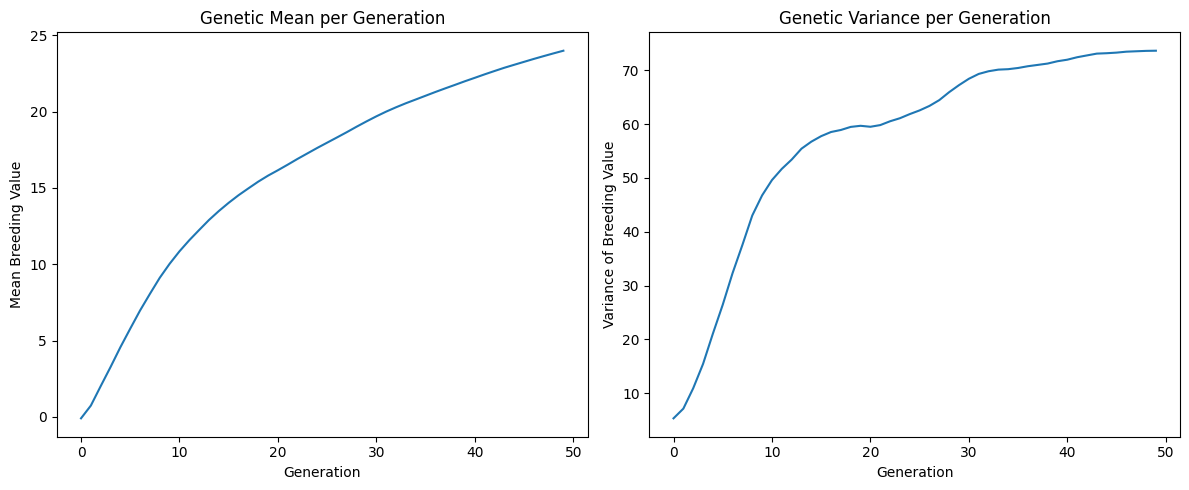

In [9]:
import jax
import jax.numpy as jnp
from jax import lax
import matplotlib.pyplot as plt
from functools import partial

# Your chewc imports...
from chewc.popgen import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.population import Population

# ... (Simulation Parameters remain the same) ...
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 20,
    "h2" : jnp.array([.3]),
    "key": jax.random.PRNGKey(42)
}
simulation_parameters['max_pop_size'] = int(
    simulation_parameters['n_founder_ind'] + \
    simulation_parameters['population_size'] * simulation_parameters['n_generations']
)


@partial(jax.jit, static_argnames=('population_size', 'n_select', 'n_chr', 'ploidy'))
def one_generation_step(carry, gen_key, sp, population_size, n_select, n_chr, ploidy):
    """
    This function executes all logic for a single generation and is JIT-compiled.
    """
    master_pop, next_id_start = carry
    current_gen_idx = jnp.max(master_pop.gen * master_pop.is_active)

    pheno_key, select_key, mate_key = jax.random.split(gen_key, 3)

    pheno_pop = set_pheno(
        key=pheno_key, pop=master_pop, traits=sp.traits,
        ploidy=ploidy, h2=simulation_parameters['h2']
    )

    is_selectable = (pheno_pop.gen == current_gen_idx) & pheno_pop.is_active
    selection_values = jnp.where(is_selectable, pheno_pop.pheno[:, 0], -jnp.inf)
    selected_iids = jnp.argsort(selection_values)[-n_select:]

    m_subkey1, m_subkey2 = jax.random.split(mate_key, 2)
    mothers = jax.random.choice(m_subkey1, selected_iids, shape=(population_size,))
    fathers = jax.random.choice(m_subkey2, selected_iids, shape=(population_size,))
    cross_plan = jnp.stack([mothers, fathers], axis=1)

    progeny_pop = make_cross(
        key=select_key, pop=pheno_pop, cross_plan=cross_plan,
        sp=sp, next_id_start=next_id_start
    )

    # --- THE FIX: Use lax.dynamic_update_slice ---
    start_idx = jnp.sum(master_pop.is_active)
    
    # This is the correct way to update a slice at a dynamic start index inside a JIT context.
    updated_geno = lax.dynamic_update_slice(master_pop.geno, progeny_pop.geno, (start_idx, 0, 0, 0))
    updated_ibd = lax.dynamic_update_slice(master_pop.ibd, progeny_pop.ibd, (start_idx, 0, 0, 0))
    updated_id = lax.dynamic_update_slice(master_pop.id, progeny_pop.id, (start_idx,))
    updated_mother = lax.dynamic_update_slice(master_pop.mother, progeny_pop.mother, (start_idx,))
    updated_father = lax.dynamic_update_slice(master_pop.father, progeny_pop.father, (start_idx,))
    updated_sex = lax.dynamic_update_slice(master_pop.sex, progeny_pop.sex, (start_idx,))
    updated_gen = lax.dynamic_update_slice(master_pop.gen, progeny_pop.gen, (start_idx,))
    updated_is_active = lax.dynamic_update_slice(master_pop.is_active, progeny_pop.is_active, (start_idx,))

    updated_pop = master_pop.replace(
        geno=updated_geno, ibd=updated_ibd, id=updated_id,
        mother=updated_mother, father=updated_father, sex=updated_sex,
        gen=updated_gen, is_active=updated_is_active
    )
    # --- END OF FIX ---

    final_pop = set_bv(updated_pop, sp.traits, ploidy)
    
    active_bvs = jnp.where(final_pop.is_active, final_pop.bv[:, 0], jnp.nan)
    genetic_mean = jnp.nanmean(active_bvs)
    genetic_variance = jnp.nanvar(active_bvs)

    new_carry = (final_pop, next_id_start + population_size)
    collected_metrics = (genetic_mean, genetic_variance)

    return new_carry, collected_metrics


# ... (The rest of your main script logic remains the same) ...
# --- 1. One-time Setup ---
key = simulation_parameters["key"]
key, founder_key, sp_key, loop_key = jax.random.split(key, 4)

# Step 1a: Create a "raw" founder population to get genotypes
raw_founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
    max_pop_size=simulation_parameters['max_pop_size']
)

sp = SimParam.from_founder_pop(founder_pop, genetic_map)
sp = add_trait_a(
    key=sp_key, founder_pop=founder_pop, sim_param=sp,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"]
)



# --- THE FIX ---
# Step 1c: Create the final founder population with all arrays correctly shaped
# This object will have a stable PyTree structure for lax.scan.

max_pop_size= simulation_parameters['max_pop_size']
n_traits =1 
founder_pop = Population(
    # Copy genotype/pedigree info from the raw population
    geno=raw_founder_pop.geno,
    ibd=raw_founder_pop.ibd,
    id=raw_founder_pop.id,
    iid=raw_founder_pop.iid,
    mother=raw_founder_pop.mother,
    father=raw_founder_pop.father,
    sex=raw_founder_pop.sex,
    gen=raw_founder_pop.gen,
    is_active=raw_founder_pop.is_active,

    # Initialize all trait-related arrays with the correct final shape
    pheno=jnp.full((max_pop_size, n_traits), jnp.nan),
    fixEff=jnp.zeros(max_pop_size, dtype=jnp.float32),
    gv=jnp.full((max_pop_size, n_traits), jnp.nan),
    bv=jnp.full((max_pop_size, n_traits), jnp.nan),
    dd=jnp.full((max_pop_size, n_traits), jnp.nan),
    aa=jnp.full((max_pop_size, n_traits), jnp.nan),
    ebv=jnp.full((max_pop_size, n_traits), jnp.nan)
)
# --- END OF FIX ---


# --- 2. Prepare for the Scan ---
n_generations = simulation_parameters["n_generations"]
initial_carry = (founder_pop, founder_pop.nInd)
generation_keys = jax.random.split(loop_key, n_generations)

# --- 3. Run the Entire Simulation with lax.scan ---
final_carry, (genetic_means, genetic_variances) = lax.scan(
    lambda carry, key: one_generation_step(
        carry, key, sp,
        simulation_parameters['population_size'],
        simulation_parameters['n_select'],
        sp.n_chr,
        sp.ploidy
    ),
    initial_carry,
    generation_keys
)

final_pop, _ = final_carry
print("Simulation complete.")
print(f"Final population has {final_pop.nInd} total individuals.")

# --- 4. Plot Results ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(genetic_means)
plt.title("Genetic Mean per Generation")
plt.xlabel("Generation")
plt.ylabel("Mean Breeding Value")

plt.subplot(1, 2, 2)
plt.plot(genetic_variances)
plt.title("Genetic Variance per Generation")
plt.xlabel("Generation")
plt.ylabel("Variance of Breeding Value")
plt.tight_layout()
plt.show()